In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import nawrapper as nw
import pymaster as nmt
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot

In [3]:
! echo $OMP_NUM_THREADS

20


# File Loading

We specify the filepaths here. In the first cell, we load in a map which has the WCS and shape information, with which we will crop all other maps to fit. When we take power spectra, we want all of the maps involved to have the same shape and WCS!

In [4]:
data_root = '/tigress/zequnl/cmb/data/from_choi/'
apopath = f'{data_root}/apo_mask/deep56_c7v5_car_190220_rect_master_apo_w0.fits'
steve_apo = enmap.read_map(apopath)
box_shape, box_wcs = steve_apo.shape, steve_apo.wcs

Next, we load in the maps and masks. In this example, the same mask is used to speed up the spectra calculation, but in general each map will have a different mask. We also apply the k-space filter at this step, with $|k_x| < 90$ and $|k_y| < 50$.

### Legacy Support
There is an important flag here, `legacy_steve = True`. At the time of this writing, Steve's code applies a slightly incorrect k-space filter, and offsets the maps by `(-1,-1)` in `WCS.CRPIX`.

In [5]:
mapname_head = f"{data_root}/maps/ACTPol_148_D56_pa1_f150_s14_4way_split"
mask_file =  f"{data_root}/window/deep56_s14_pa1_f150_c7v5_car_190220_rect_w0_cl0.00nK_pt1.00_nt0.0_T.fits"
mask_pol_file =  f"{data_root}/window/deep56_s14_pa1_f150_c7v5_car_190220_rect_w0_cl0.00nK_pt1.00_nt0.0.fits"
beam_filename = f"{data_root}/beam/beam_tform_160201_s14_pa1_f150_jitter_CMB_deep56.txt"

# loop over splits and generate 
nsplits = 4
namap_list = [nw.namap_car(
    maps=(enmap.read_map(f"{mapname_head}{i}_srcadd_I.fits"), 
          enmap.read_map(f"{mapname_head}{i}_Q.fits"),
          enmap.read_map(f"{mapname_head}{i}_U.fits")),
    masks=(enmap.read_map(mask_file), enmap.read_map(mask_pol_file)), 
    beams=nw.read_beam(beam_filename),
    legacy_steve=True, kx=90, ky=50, sub_wcs=box_wcs, sub_shape=box_shape)
              for i in range(nsplits)]

Assuming the same beams for both I and QU.
Creating a car namap. temperature: True, polarization: True
Applying legacy_steve correction.
Applying a k-space filter (kx=90, ky=50, apo=40), unpixwin: True
Computing spherical harmonics.

Assuming the same beams for both I and QU.
Creating a car namap. temperature: True, polarization: True
Applying legacy_steve correction.
Applying a k-space filter (kx=90, ky=50, apo=40), unpixwin: True
Computing spherical harmonics.

Assuming the same beams for both I and QU.
Creating a car namap. temperature: True, polarization: True
Applying legacy_steve correction.
Applying a k-space filter (kx=90, ky=50, apo=40), unpixwin: True
Computing spherical harmonics.

Assuming the same beams for both I and QU.
Creating a car namap. temperature: True, polarization: True
Applying legacy_steve correction.
Applying a k-space filter (kx=90, ky=50, apo=40), unpixwin: True
Computing spherical harmonics.



### optional: load mode-coupling matrix from disk
You can run this cell to load a mode-coupling matrix from disk, and skip the computation of the mode coupling matrix (in the cell after) for this example, if you're on a Princeton cluster with access to the tigress filesystem.

In [6]:
mc = nw.mode_coupling(mcm_dir='/tigress/zequnl/cmb/data/choi_example_mc')
bins = mc.bins

### otherwise

We compute the mode coupling matrix from namaps. We will reuse this for all spectra calculations. 

If you're on tiger/della/perseus, you can skip the next cell which is very expensive, and run with a precomputed mode-coupling matrix. The following cell won't run if the mode coupling object already exists.
### Compute Mode-Coupling Matrix (expensive):

In [7]:
if 'mc' not in locals(): # make sure we had not read the matrix from disk already
    binfile = f'{data_root}/binning/BIN_ACTPOL_50_4_SC_low_ell'
    bins = nw.read_bins(binfile, is_Dell=True)
    mc = nw.mode_coupling(namap_list[0], namap_list[1], bins)

In [8]:
# example: write mode-coupling matrix results to directory
# mc.write_to_dir('/tigress/zequnl/cmb/data/choi_example_mc')

# Computing Spectra

Next, we apply the mode coupling matrix to each pair of `namap` objects. We will reuse the mode coupling object we computed, since all the masks are the same in this toy example. We take a flat mean of the 4 choose 2 = 6 cross spectra, and also compute the standard error.

In [9]:
spec_dict = {}
TT_cross_spectra = []
TE_cross_spectra = []
EE_cross_spectra = []
# we reuse the mode coupling matrix `mc` from earlier
for i in range(len(namap_list)):
    for j in range(len(namap_list)):
        if i >= j:
            Cb = nw.compute_spectra(
                namap_list[i], namap_list[j], mc=mc)
            for clXY in Cb:
                spec_dict[f"{clXY},{i},{j}"] = Cb[clXY]
            if i > j:
                TT_cross_spectra += [Cb['TT']]
                TE_cross_spectra += [Cb['TE']]
                TE_cross_spectra += [Cb['ET']]
                EE_cross_spectra += [Cb['EE']]

In [10]:
mean_Cltt = np.sum(TT_cross_spectra, axis=0) / len(TT_cross_spectra)
se_Cltt = np.std(TT_cross_spectra, axis=0)/np.sqrt(len(TT_cross_spectra))

# Check Our Results

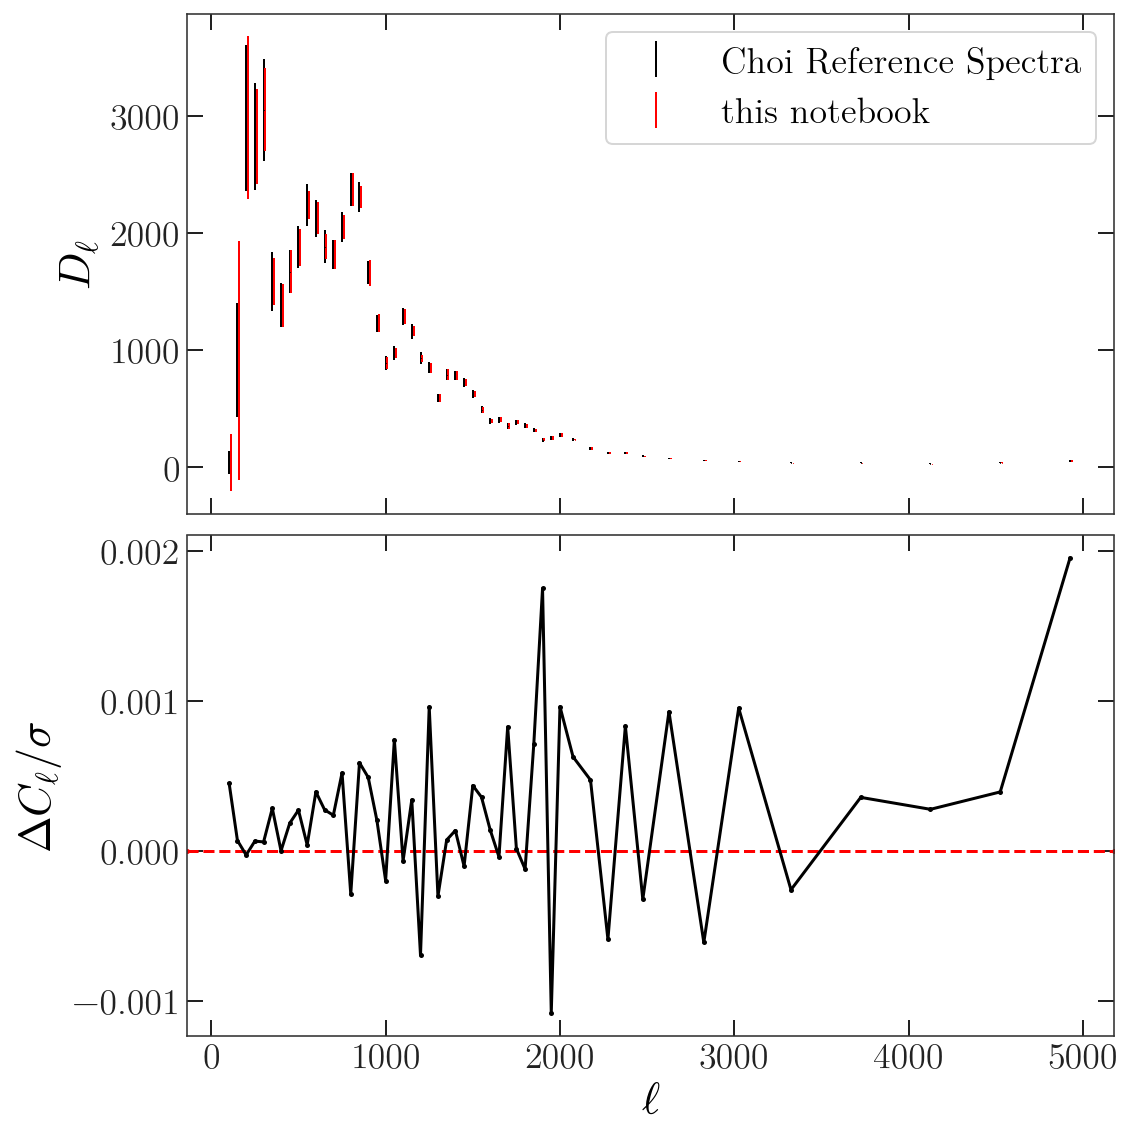

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(8,8), sharex=True)

# plot steve spectra
specfile = f"{data_root}/ps/deep56_s14_pa1_f150_c7v5_car_190220_rect_window0_TT_lmax7925_fsky0.01081284_output.txt"
choi_ell, choi_dl, choi_delta_dl, _ = np.loadtxt(specfile, unpack=True)[:,2:54]
axes[0].errorbar( choi_ell, choi_dl, yerr=choi_delta_dl, fmt='k.', 
                 lw=1, ms=1, label="Choi Reference Spectra" )
# plot our spectra
lb = mc.lb[1:-3]
notebook_dl = mean_Cltt[1:-3] 
axes[0].errorbar(lb + 10, notebook_dl, # we slightly offset to not overlap
                 fmt='r.', 
                 yerr=(notebook_dl / np.sqrt(2 * lb + 1) + se_Cltt[1:-3]),
                 lw=1, ms=1, label="this notebook")
axes[0].set_ylabel(r"$D_{\ell}$")
axes[0].legend(frameon=True)

# plot ratio
axes[1].axhline(0.0, ls='dashed', color='red')
axes[1].plot( lb, (notebook_dl - choi_dl) / choi_delta_dl )
axes[1].set_ylabel('$ \Delta C_{\ell} / \sigma$')
axes[1].set_xlabel(r'$\ell$')
plt.tight_layout()

We also computed the polarization power spectra, so here we plot them.

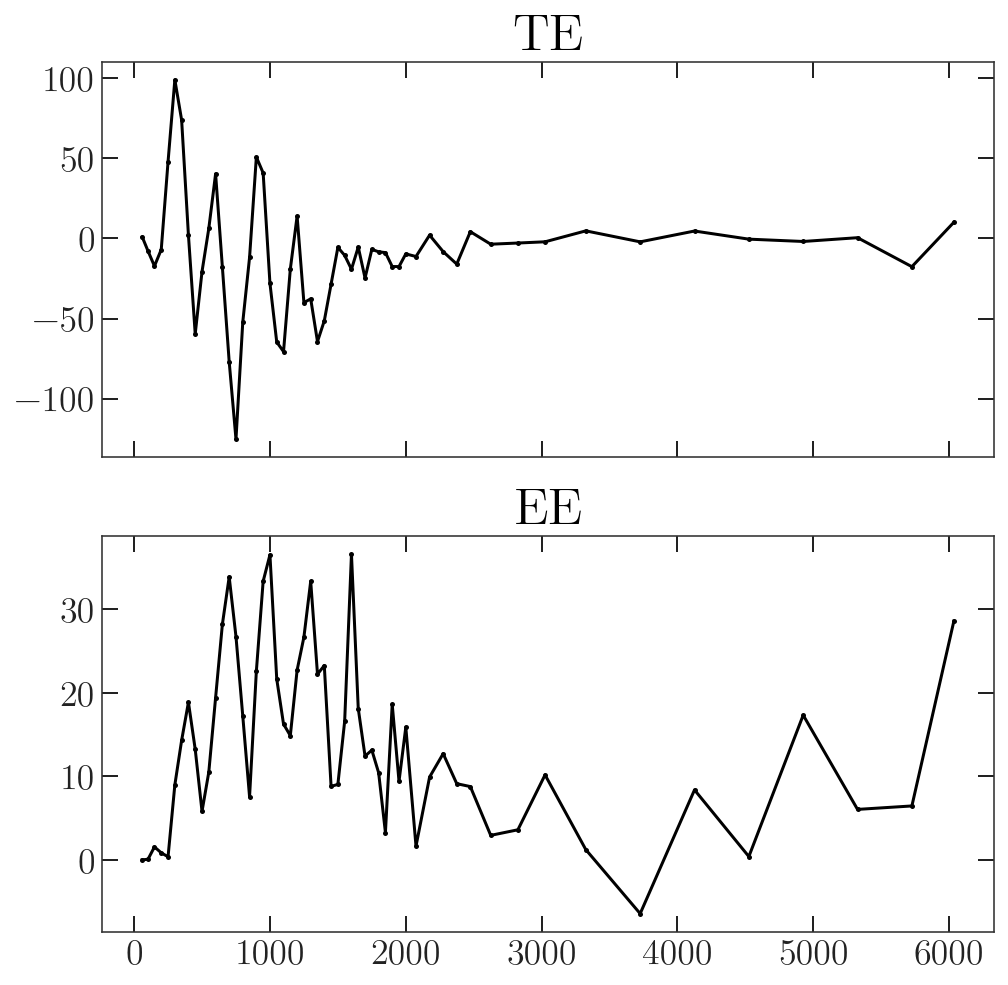

In [12]:
fig, axes = plt.subplots(2,1, sharex=True, figsize=(8,8))
axes[0].set_title("TE")
mean_Clte = np.sum(TE_cross_spectra, axis=0) / len(TE_cross_spectra)
axes[0].plot(mc.lb, mean_Clte)

axes[1].set_title("EE")
mean_Clee = np.sum(EE_cross_spectra, axis=0) / len(EE_cross_spectra)
axes[1].plot(mc.lb, mean_Clee)

# Bandpower Windows

In [13]:
bpw = mc.w00.get_bandpower_windows()

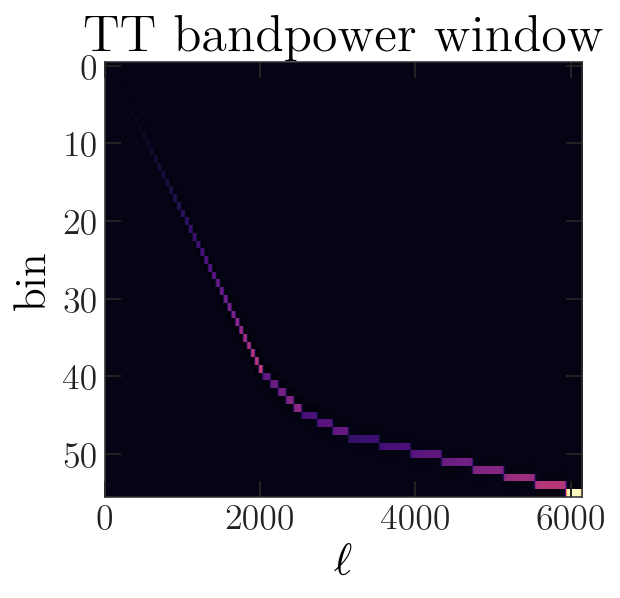

In [14]:
plt.imshow(bpw.reshape(56,6144), aspect=100)
plt.ylabel('bin')
plt.xlabel(r'$\ell$')
plt.title('TT bandpower window');